Available data folders:
1. 2024-08-16-20-13-accl-output
2. Enter custom path
Enter the number of your choice: 1
Selected folder: accelerometer_data/2024-08-16-20-13-accl-output


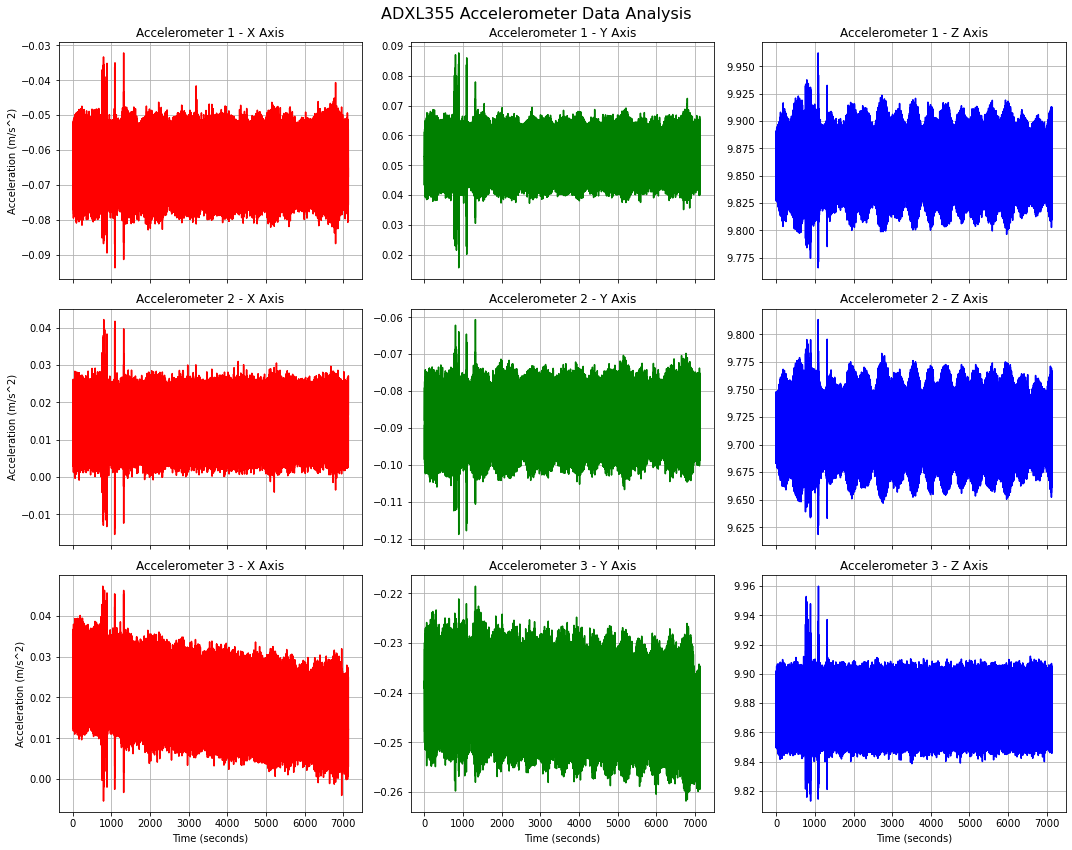


Sampling Rate Statistics - Accelerometer 1:
Mean: 1000.03 Hz
Median: 1000.07 Hz
Std Dev: 14.02 Hz
Min: 475.65 Hz
Max: 9845.72 Hz

Sampling Rate Statistics - Accelerometer 2:
Mean: 1000.03 Hz
Median: 1000.07 Hz
Std Dev: 14.02 Hz
Min: 475.65 Hz
Max: 9845.72 Hz

Sampling Rate Statistics - Accelerometer 3:
Mean: 1000.03 Hz
Median: 1000.07 Hz
Std Dev: 14.02 Hz
Min: 475.65 Hz
Max: 9845.72 Hz


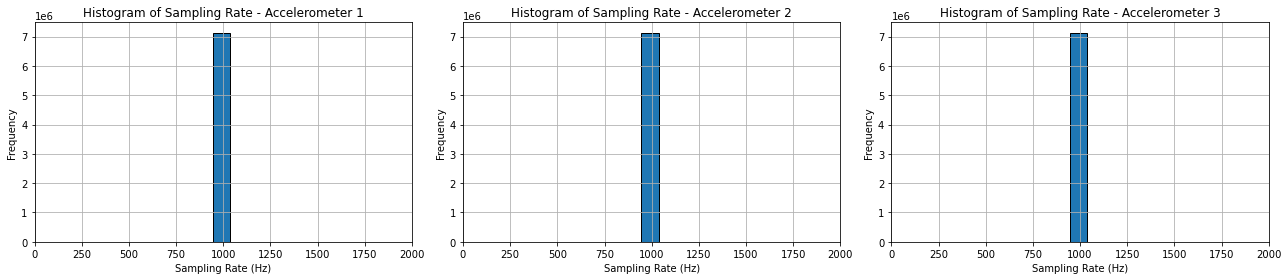


Accelerometer 1:
Total number of samples: 7129568
Time span: 0 days 01:58:49.567054033
First timestamp: 2024-08-17 00:13:15.703941345
Last timestamp: 2024-08-17 02:12:05.270995378

Accelerometer 2:
Total number of samples: 7129568
Time span: 0 days 01:58:49.567054033
First timestamp: 2024-08-17 00:13:15.703941345
Last timestamp: 2024-08-17 02:12:05.270995378

Accelerometer 3:
Total number of samples: 7129568
Time span: 0 days 01:58:49.567054033
First timestamp: 2024-08-17 00:13:15.703941345
Last timestamp: 2024-08-17 02:12:05.270995378


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import struct

def select_folder():
    """
    Provide an interactive prompt for the user to select a data folder.
    Returns:
    str: Path to the selected folder.
    """
    base_path = 'accelerometer_data'
    folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    print("Available data folders:")
    for i, folder in enumerate(folders, 1):
        print(f"{i}. {folder}")
    print(f"{len(folders) + 1}. Enter custom path")
    
    while True:
        try:
            choice = int(input("Enter the number of your choice: "))
            if 1 <= choice <= len(folders):
                return os.path.join(base_path, folders[choice - 1])
            elif choice == len(folders) + 1:
                custom_path = input("Enter the custom path: ")
                if os.path.isdir(custom_path):
                    return custom_path
                else:
                    print("Invalid path. Please try again.")
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def load_and_process_bin_files(folder_path):
    """
    Load and process all .bin files from the specified folder for three accelerometers.
    Parameters:
    folder_path (str): Path to the folder containing .bin files.
    Returns:
    tuple: Three DataFrames with processed ADXL355 data for each accelerometer.
    """
    all_data = {1: [], 2: [], 3: []}
    file_pattern = re.compile(r'(\d+\.\d+)_chunk_\d+\.bin')
    
    for accel_id in [1, 2, 3]:
        accel_folder = os.path.join(folder_path, f'accl{accel_id}')
        for filename in sorted(os.listdir(accel_folder)):
            if filename.endswith('.bin'):
                match = file_pattern.match(filename)
                if match:
                    file_path = os.path.join(accel_folder, filename)
                    with open(file_path, 'rb') as f:
                        chunk_data = []
                        while True:
                            data = f.read(32)  # 4 doubles, each 8 bytes
                            if not data:
                                break
                            values = struct.unpack('dddd', data)
                            chunk_data.append(values)
                    all_data[accel_id].extend(chunk_data)
    
    if not all_data[1] or not all_data[2] or not all_data[3]:
        raise ValueError("No valid .bin files found for one or more accelerometers.")
    
    dfs = {}
    for accel_id in [1, 2, 3]:
        df = pd.DataFrame(all_data[accel_id], columns=['Timestamp', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        df.set_index('Timestamp', inplace=True)
        start_time = df.index[0]
        df['Time_elapsed'] = (df.index - start_time).total_seconds()
        dfs[accel_id] = df
    
    return dfs[1], dfs[2], dfs[3]

def plot_adxl355_data(df1, df2, df3):
    """
    Plot ADXL355 accelerometer data for all three accelerometers.
    Parameters:
    df1, df2, df3 (pd.DataFrame): DataFrames with ADXL355 data for each accelerometer.
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
    fig.suptitle('ADXL355 Accelerometer Data Analysis', fontsize=16)
    
    for i, (df, title) in enumerate(zip([df1, df2, df3], ['Accelerometer 1', 'Accelerometer 2', 'Accelerometer 3'])):
        axes[i, 0].plot(df['Time_elapsed'].to_numpy(), df['X (m/s^2)'].to_numpy(), 'r-')
        axes[i, 0].set_ylabel('Acceleration (m/s^2)')
        axes[i, 0].set_title(f'{title} - X Axis')
        axes[i, 0].grid(True)
        
        axes[i, 1].plot(df['Time_elapsed'].to_numpy(), df['Y (m/s^2)'].to_numpy(), 'g-')
        axes[i, 1].set_title(f'{title} - Y Axis')
        axes[i, 1].grid(True)
        
        axes[i, 2].plot(df['Time_elapsed'].to_numpy(), df['Z (m/s^2)'].to_numpy(), 'b-')
        axes[i, 2].set_title(f'{title} - Z Axis')
        axes[i, 2].grid(True)
    
    for ax in axes[-1, :]:
        ax.set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()

def analyze_sampling_rate(df1, df2, df3):
    """
    Analyze and plot the sampling rate of ADXL355 data for all three accelerometers.
    Parameters:
    df1, df2, df3 (pd.DataFrame): DataFrames with ADXL355 data for each accelerometer.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    for df, ax, accel_id in zip([df1, df2, df3], [ax1, ax2, ax3], [1, 2, 3]):
        time_diff = df.index.to_series().diff().dt.total_seconds()
        sampling_rate = 1 / time_diff
        sampling_rate = sampling_rate[np.isfinite(sampling_rate)]
        
        ax.hist(sampling_rate, bins=100, edgecolor='black')
        ax.set_title(f'Histogram of Sampling Rate - Accelerometer {accel_id}')
        ax.set_xlabel('Sampling Rate (Hz)')
        ax.set_ylabel('Frequency')
        ax.set_xlim(0, 2000)
        ax.grid(True)
        
        print(f"\nSampling Rate Statistics - Accelerometer {accel_id}:")
        print(f"Mean: {sampling_rate.mean():.2f} Hz")
        print(f"Median: {sampling_rate.median():.2f} Hz")
        print(f"Std Dev: {sampling_rate.std():.2f} Hz")
        print(f"Min: {sampling_rate.min():.2f} Hz")
        print(f"Max: {sampling_rate.max():.2f} Hz")
    
    plt.tight_layout()
    plt.show()

def main():
    folder_path = select_folder()
    print(f"Selected folder: {folder_path}")
    
    df1, df2, df3 = load_and_process_bin_files(folder_path)

    # Plot the acceleration data for all three accelerometers
    plot_adxl355_data(df1, df2, df3)

    # Analyze and plot sampling rate for all three accelerometers
    analyze_sampling_rate(df1, df2, df3)

    # Print some basic information about the datasets
    for i, df in enumerate([df1, df2, df3], 1):
        print(f"\nAccelerometer {i}:")
        print(f"Total number of samples: {len(df)}")
        print(f"Time span: {df.index[-1] - df.index[0]}")
        print(f"First timestamp: {df.index[0]}")
        print(f"Last timestamp: {df.index[-1]}")

if __name__ == "__main__":
    main()